In [81]:
import sys
sys.path.append('/Users/hph/current_fits/cutout_figures/')
path = '/Users/hph/current_fits/cutout_figures/'
import numpy as np
import matplotlib.pyplot as plt
import aplpy
from astropy.io import fits
from astropy import wcs
import warnings
#import regions
import pyregion
from astropy import wcs
from reproject import reproject_interp
from astropy.utils.console import ProgressBar

In [102]:
def cutout(inputfile, xcenter, ycenter, width, height, cdelt = '',
           ranges = False, path='/Users/hph/cmzoom_catalog/catalog_acc/cutouts/', outfile = ''):

    ### This function creates a new fits file based on rectangular region information.
    ### xcenter, ycenter are the centers of the region in galactic longitude and latitude in degrees
    ### width and height are similarly longitude and latitude measurements in degrees
    
    w = wcs.WCS(path+inputfile).celestial

    data, header = fits.getdata(path+inputfile, header = True)
        
    #if (header['CRVAL1'] != 0) or (header['CRVAL2'] != 0):
    #    raise ValueError('\nThe input CRVAL is not 0!\n')
    
    
    

    centre_x, centre_y = w.wcs_world2pix(xcenter, ycenter, 1)
    #print centre_x
    #print centre_y

    centre_x = int(centre_x)
    centre_y = int(centre_y)
    
    
    if cdelt == '':
        cdelt = np.mean( [np.absolute(header['CDELT1']), np.absolute(header['CDELT2'])] )
    cdelt = cdelt
        
        
    size_pixels_x = int(np.rint((width / 2.) / cdelt))
    size_pixels_y = int(np.rint((height / 2.) / cdelt))

    
    delta_y = np.array([centre_x - size_pixels_x, centre_x + size_pixels_x], dtype = int)
    delta_x = np.array([centre_y - size_pixels_y, centre_y + size_pixels_y], dtype = int)
    
    centre_x_new, centre_y_new  = w.wcs_pix2world( delta_y[0], delta_x[0], 1)
        
    data_cutout = data[ delta_x[0]: delta_x[1], delta_y[0]: delta_y[1] ]

    centre_x = ((delta_x[1] - delta_x[0]) / 2.) + delta_x[0]
    centre_y = ((delta_y[1] - delta_y[0]) / 2.) + delta_y[0]

    # centre_x_new, centre_y_new  = ((delta_x[1] - delta_x[0]) / 2.), ((delta_y[1] - delta_y[0]) / 2.)
    # centre_x_new_world, centre_y_new_world, velo  = w.wcs_pix2world(centre_y, centre_x, 0, 1)

    centre_x_new, centre_y_new = (header['CRPIX1'] - delta_y[0]), (header['CRPIX2'] - delta_x[0])

    if ranges: 
    
        stats = [np.nanmin(data_cutout), np.nanmax(data_cutout)]
        return stats
    
    if outfile != '':
        
        #del header[29:72]
        del header['PC*']
        
        header['CRPIX1'] = size_pixels_x #float(centre_y) #_new
        header['CRPIX2'] = size_pixels_y #float(centre_x) #_new 
        header['CRVAL1'] = xcenter #float(centre_y_new_world) 
        header['CRVAL2'] = ycenter #float(centre_x_new_world)
    
        fits.writeto(path+outfile, data = data_cutout, header = header, overwrite = True)
        


def make_single(inputfits, outputfile, xcenter, ycenter, label, vmin=-1.14125e08, vmax =2.07402e+08, gamma=1.8):
    
    path = '/Users/hph/cmzoom_catalog/catalog_acc/cutouts/'
    
    fg_color='white'
    bg_color='black'
    fig = plt.figure(figsize=(5, 5))#,facecolor=bg_color, edgecolor=fg_color)
    subplot = aplpy.FITSFigure(inputfits, figure = fig, convention='calabretta')
    subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='power',exponent=gamma,cmap='inferno')
    #subplot.set_nan_color(bg_color)
    subplot.set_nan_color(fg_color)

    subplot.ticks.set_xspacing(0.02)
    subplot.ticks.set_yspacing(0.02)
    subplot.ticks.set_color('black')
    subplot.tick_labels.set_xformat('d.dd')
    subplot.tick_labels.set_yformat('d.dd')
    subplot.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'black')

    subplot.show_contour(path+'dendrogram_mask_pruned_rms1e7_dv3_dd1_dp50_pp6_pm2_gal_5-28-19.fits',
                         colors = 'white', levels = [0.0,1.0], linewidths = 0.7,
                         convention = 'calabretta', zorder = 10, linestyle = 'solid')
    subplot.axis_labels.set_xtext('Galactic Longitude (degrees)')
    subplot.axis_labels.set_ytext('Galactic Latitude (degrees)')
    subplot.ticks.show()
    subplot.add_scalebar(length=24./3600.)
    subplot.scalebar.set_label('1 pc')
    subplot.add_beam(color=white)
    subplot.scalebar.set_color('white')
    #fig.tight_layout()
    fig.savefig(outputfile)
    plt.show()
    #plt.close('all')
    


In [8]:
###################################################
### single use cutout:
###################################################
cutout('Continuum_mosaic_current_no_sgra_no_IHMSFR.fits', 
       0.3781046312, 0.04874423644, 
       0.1336001, 0.0728000, 
       outfile = 'dustridge_BCD.fits')


In [ ]:
###################################################
### single use postage figure:
###################################################
make_single(inputfits = path+'dustridge_BCD.fits',outputfile=path+'dustridge_BCD.pdf', 
            xcenter = 0.3781046312, ycenter = 0.04874423644, 
            label = 'Dust Ridge cloud B, C, and D')

In [9]:
###################################################
### Load list of pyregions to cutout
###################################################
path = '/Users/hph/cmzoom_catalog/catalog_acc/cutouts/'
reglist = pyregion.open(path+'cutouts.reg')


In [10]:
###################################################
### Generate cutout fits files for each region
###################################################
for reg_i in range(len(reglist)):
    reg = reglist[reg_i]
    cutout(inputfile='CMZoom_continuum_pbcor.fits',
           xcenter = reg.coord_list[0], ycenter = reg.coord_list[1],
           width = reg.coord_list[2], height = reg.coord_list[3],
           outfile = "cutout_"+str(reg_i)+".fits")

In [11]:
###################################################
### Generate postage figure for each region
###################################################

for reg_i in range(len(reglist)):
    make_single(inputfits = path+'cutout_'+str(reg_i)+'.fits',outputfile=path+'cutout_'+str(reg_i)+'.pdf', 
                    xcenter = reglist[reg_i].coord_list[0], ycenter = reglist[reg_i].coord_list[1], 
                    label = '',vmin=1.0e7,vmax =3.0e8)
    plt.close()


In [7]:
###################################################
### single use cutout:
###################################################
path='/Users/hph/cmzoom_catalog/catalog_acc/'
###################################################
### Generate cutout fits files for each region
###################################################
reglist = pyregion.open(path+'cmz_column_map.reg')
reg = reglist[0]
cutout(inputfile='column_properunits_conv36_source_only.fits',
       xcenter = reg.coord_list[0], ycenter = reg.coord_list[1],
       width = reg.coord_list[2], height = reg.coord_list[3], path = path,
       outfile = "cmz_column_submap"+".fits")


In [104]:
####################################################
### make alma comparison cutouts: Sgr B2
####################################################
path = '/Users/hph/cmzoom_catalog/alma_comparison/'
sgrb2_sma = fits.open(path+'CMZoom_continuum_pbcor_reshaped.fits')
sgrb2_alma = fits.open(path+'SgrB2_selfcal_full_TCTE7m_try2_selfcal6_ampphase_robust-1.image.tt0.pbcor.fits')
dr_ef_sma = fits.open(path+'CMZoom_continuum_pbcor_reshaped.fits')
dr_ef_alma = fits.open(path+'cloud_ef.v6.3.tc5.gal.feathered.defaults.nostokes.fits')
dr_d_sma = fits.open(path+'CMZoom_continuum_pbcor_reshaped.fits')
dr_d_alma = fits.open(path+'cloud_d.v5.3.tc6.5.gal.feathered.defaults.nostokes.fits')
mask = fits.open(path+'dendrogram_mask_pruned_rms3e6_k14_dv3_dd1_dp17_pp6_pm2_gal_02-02-20.fits')
#wcs_alma = wcs.WCS(sgrb2_alma[0].header)
#wcs_sma = wcs.WCS(sgrb2_sma[0].header).celestial

array, footprint = reproject_interp(sgrb2_sma,sgrb2_alma[0].header)
fits.writeto(path+'sgrb2_sma2alma.fits', array, sgrb2_alma[0].header, overwrite=True)

array, footprint = reproject_interp(dr_ef_sma,dr_ef_alma[0].header)
fits.writeto(path+'dr_ef_sma2alma.fits', array, sgrb2_alma[0].header, overwrite=True)

array, footprint = reproject_interp(dr_d_sma,dr_d_alma[0].header)
fits.writeto(path+'dr_d_sma2alma.fits', array, sgrb2_alma[0].header, overwrite=True)

# array, footprint = reproject_interp(mask,sgrb2_alma[0].header)
# fits.writeto(path+'sgrb2_mask.fits', array, sgrb2_alma[0].header, overwrite=True)


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


In [106]:
####################################################
### make alma comparison cutouts: Sgr B2
####################################################
path = '/Users/hph/cmzoom_catalog/alma_comparison/'

cutout(inputfile='SgrB2_selfcal_full_TCTE7m_try2_selfcal6_ampphase_robust-1.image.tt0.pbcor.fits',
       xcenter = 266.8332, ycenter = -28.3819,
       width = 0.02611, height = 0.04216, path = path,
       outfile = "sgrb2_submap_alma.fits")

cutout(inputfile='sgrb2_sma2alma.fits',
       xcenter = 266.8332, ycenter = -28.3819,
       width = 0.02611, height = 0.04216, path = path,
       outfile = "sgrb2_submap_sma.fits")

cutout(inputfile='cloud_ef.v6.3.tc5.gal.feathered.defaults.nostokes.fits',
       xcenter = 0.4852510, ycenter = 0.0037451,
       width = 0.0368935, height = 0.0529514, path = path,
       outfile = "dr_ef_submap_alma.fits")

cutout(inputfile='CMZoom_continuum_pbcor_reshaped.fits',
       xcenter = 0.4852510, ycenter = 0.0037451,
       width = 0.0368935, height = 0.0529514, path = path,
       outfile = "dr_ef_submap_sma.fits")

cutout(inputfile='cloud_d.v5.3.tc6.5.gal.feathered.defaults.nostokes.fits',
       xcenter = 0.4141903, ycenter = 0.0513437,
       width = 0.0286654, height = 0.0466673, path = path,
       outfile = "dr_d_submap_alma.fits")

cutout(inputfile='CMZoom_continuum_pbcor_reshaped.fits',
       xcenter = 0.4141903, ycenter = 0.0513437,
       width = 0.0286654, height = 0.0466673, path = path,
       outfile = "dr_d_submap_sma.fits")


KeyboardInterrupt: 

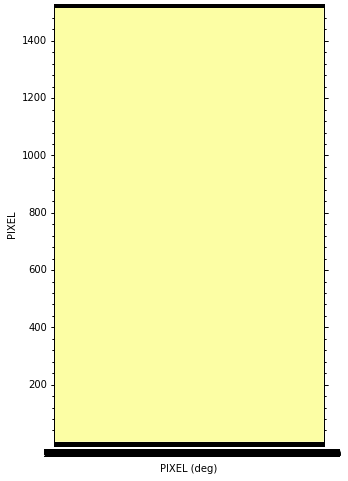

In [101]:
fg_color='white'
bg_color='black'
vmin-1e-4
vmax=0.1
gamma=1.8
plt.close()
fig = plt.figure(figsize=(5, 8))#,facecolor=bg_color, edgecolor=fg_color)
subplot = aplpy.FITSFigure(path+'sgrb2_submap_alma.fits', figure = fig, convention='calabretta')
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='power',exponent=gamma,cmap='inferno')
#subplot.set_nan_color(bg_color)
#subplot.set_nan_color('w')

subplot.ticks.set_xspacing(0.02)
subplot.ticks.set_yspacing(0.02)
subplot.ticks.set_color('black')
subplot.tick_labels.set_xformat('d.dd')
subplot.tick_labels.set_yformat('d.dd')
#subplot.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'black')

subplot.show_contour(path+'dendrogram_mask_pruned_rms3e6_k14_dv3_dd1_dp17_pp6_pm2_gal_02-02-20.fits',
                     colors = 'white', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.axis_labels.set_xtext('Galactic Longitude (degrees)')
subplot.axis_labels.set_ytext('Galactic Latitude (degrees)')
subplot.ticks.show()
subplot.add_scalebar(length=24./3600.)
subplot.scalebar.set_label('1 pc')
subplot.scalebar.set_color('white')
#fig.tight_layout()
fig.savefig(path+'sgrb2_alma.pdf')

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:165: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:165: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:165: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid 

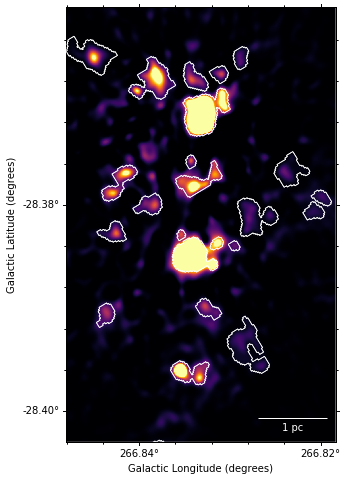

In [99]:
fg_color='white'
bg_color='black'
vmin=-1.14125e08
vmax=3.07402e+09
gamma=1.8
plt.close()
fig = plt.figure(figsize=(5, 8))#,facecolor=bg_color, edgecolor=fg_color)
subplot = aplpy.FITSFigure(path+'sgrb2_submap_sma.fits', figure = fig, convention='calabretta')
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='power',exponent=gamma,cmap='inferno')
#subplot.set_nan_color(bg_color)
subplot.set_nan_color('w')

subplot.ticks.set_xspacing(0.02)
subplot.ticks.set_yspacing(0.02)
subplot.ticks.set_color('black')
subplot.tick_labels.set_xformat('d.dd')
subplot.tick_labels.set_yformat('d.dd')
#subplot.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'black')

subplot.show_contour(path+'sgrb2_mask.fits',
                     colors = 'white', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.axis_labels.set_xtext('Galactic Longitude (degrees)')
subplot.axis_labels.set_ytext('Galactic Latitude (degrees)')
subplot.ticks.show()
subplot.add_scalebar(length=24./3600.)
subplot.scalebar.set_label('1 pc')
subplot.scalebar.set_color('white')
#fig.tight_layout()
fig.savefig(path+'sgrb2_sma.pdf')

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)


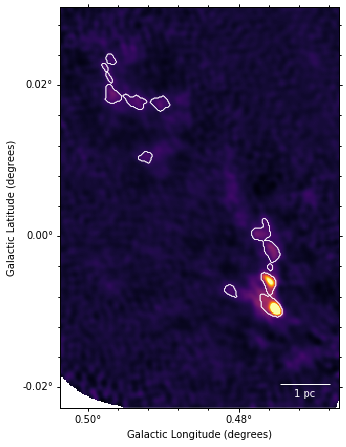

In [111]:
fg_color='white'
bg_color='black'
vmin=-1.14125e08
vmax=3.07402e+08
gamma=1.8
plt.close()
fig = plt.figure(figsize=(5, 8))#,facecolor=bg_color, edgecolor=fg_color)
subplot = aplpy.FITSFigure(path+'dr_ef_submap_sma.fits', figure = fig, convention='calabretta')
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='power',exponent=gamma,cmap='inferno')
#subplot.set_nan_color(bg_color)
subplot.set_nan_color('w')

subplot.ticks.set_xspacing(0.02)
subplot.ticks.set_yspacing(0.02)
subplot.ticks.set_color('black')
subplot.tick_labels.set_xformat('d.dd')
subplot.tick_labels.set_yformat('d.dd')
#subplot.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'black')

subplot.show_contour(path+'dendrogram_mask_pruned_rms3e6_k14_dv3_dd1_dp17_pp6_pm2_gal_02-02-20.fits',
                     colors = 'white', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.axis_labels.set_xtext('Galactic Longitude (degrees)')
subplot.axis_labels.set_ytext('Galactic Latitude (degrees)')
subplot.ticks.show()
subplot.add_scalebar(length=24./3600.)
subplot.scalebar.set_label('1 pc')
subplot.scalebar.set_color('white')
#fig.tight_layout()
fig.savefig(path+'dr_ef_sma.pdf')

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)


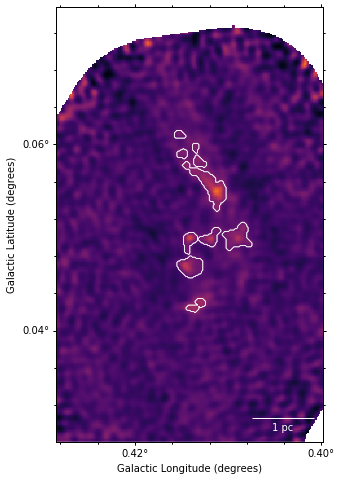

In [115]:
fg_color='white'
bg_color='black'
vmin=-1.14125e08
vmax=1.57402e+08
gamma=1.8
plt.close()
fig = plt.figure(figsize=(5, 8))#,facecolor=bg_color, edgecolor=fg_color)
subplot = aplpy.FITSFigure(path+'dr_d_submap_sma.fits', figure = fig, convention='calabretta')
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='power',exponent=gamma,cmap='inferno')
#subplot.set_nan_color(bg_color)
subplot.set_nan_color('w')

subplot.ticks.set_xspacing(0.02)
subplot.ticks.set_yspacing(0.02)
subplot.ticks.set_color('black')
subplot.tick_labels.set_xformat('d.dd')
subplot.tick_labels.set_yformat('d.dd')
#subplot.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'black')

subplot.show_contour(path+'dendrogram_mask_pruned_rms3e6_k14_dv3_dd1_dp17_pp6_pm2_gal_02-02-20.fits',
                     colors = 'white', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.axis_labels.set_xtext('Galactic Longitude (degrees)')
subplot.axis_labels.set_ytext('Galactic Latitude (degrees)')
subplot.ticks.show()
subplot.add_scalebar(length=24./3600.)
subplot.scalebar.set_label('1 pc')
subplot.scalebar.set_color('white')
#fig.tight_layout()
fig.savefig(path+'dr_d_sma.pdf')